In [1]:
import scipy.stats as scs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import auc, roc_curve, classification_report,precision_recall_curve
import seaborn as sns
from dateutil.relativedelta import relativedelta
from lightgbm.sklearn import LGBMClassifier
from src.clean_engine import process_df_clean,whole_process
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction import DictVectorizer


from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from pdpbox import pdp, info_plots
seed = 42

/Users/dwight/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def roc_pr_curve_plot(trained_model, X_train, y_train, X_test, y_test):
    '''
    A customized visualization hanlder
    '''
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-0.05,1.05])
    ax1.set_ylim([-0.05,1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_xlim([-0.05,1.05])
    ax2.set_ylim([-0.05,1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')

    pred_prob = trained_model.predict_proba(X_train)[:,1]

    p_train,r_train,_ = precision_recall_curve(y_train,pred_prob)
    tpr_train,fpr_train,_ = roc_curve(y_train,pred_prob) 

    ax1.plot(r_train,p_train,c='r',label='train')
    ax2.plot(tpr_train,fpr_train,c='r',label='train')

    pred_prob = trained_model.predict_proba(X_test)[:,1]

    p_test,r_test,_ = precision_recall_curve(y_test,pred_prob)
    tpr_test,fpr_test,_ = roc_curve(y_test,pred_prob) 

    ax1.plot(r_test,p_test,c='b',label='test')
    ax2.plot(tpr_test,fpr_test,c='b',label='test')
    ax1.legend(loc='lower left')    
    ax2.legend(loc='lower left')
    return fig

In [3]:
df1 = pd.read_csv('course_hero_data/DS_interview_doc.csv')
df2 = pd.read_csv('course_hero_data/DS_interview_paid_unlock.csv')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
New_ID                10000 non-null int64
date                  10000 non-null object
year_month            10000 non-null object
byte_size             10000 non-null int64
filetype              10000 non-null object
school_country        10000 non-null object
school_name           10000 non-null object
school_type           10000 non-null object
enrollment            9932 non-null float64
first_subject_name    10000 non-null object
tag                   9999 non-null object
page_count            10000 non-null float64
hqd_score             9789 non-null float64
is_mcq                415 non-null float64
top_keywords          10000 non-null int64
language              9575 non-null object
course_id_            10000 non-null int64
user_id_              10000 non-null int64
dtypes: float64(4), int64(5), object(9)
memory usage: 1.4+ MB


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38868 entries, 0 to 38867
Data columns (total 3 columns):
New_ID         38868 non-null int64
unlock_date    38868 non-null object
unlock_cnt     38868 non-null int64
dtypes: int64(2), object(1)
memory usage: 911.0+ KB


In [6]:
df1.head()

,New_ID,date,year_month,byte_size,filetype,school_country,school_name,school_type,enrollment,first_subject_name,tag,page_count,hqd_score,is_mcq,top_keywords,language,course_id_,user_id_
0,880,2017-11-19,2017-11,48940,docx,United States,Fordham University,HIGHER,17901.0,accounting,paper,4.0,0.95683,NaN,1,NaN,0,0
1,881,2016-06-10,2016-06,5336,docx,United States,Rio Salado Community College,HIGHER,6086.0,economics,paper,1.0,0.77776,NaN,0,english,1,1
2,882,2017-03-20,2017-03,18034,docx,United States,University of Phoenix,HIGHER,212044.0,sociology,paper,3.0,0.94462,NaN,1,english,2,2
3,883,2018-01-28,2018-01,16518,docx,Canada,University of Waterloo,HIGHER,36670.0,history,notes,3.0,0.96980,NaN,0,english,3,3
4,884,2017-06-11,2017-06,88860,docx,United States,"University of California, Santa Barbara",HIGHER,25833.0,sociology,notes,4.0,0.96610,NaN,1,english,4,4


In [7]:
df2.head()

,New_ID,unlock_date,unlock_cnt
0,6488,2016-07-25,1
1,6488,2017-05-03,1
2,6488,2017-05-03,1
3,6488,2017-10-28,1
4,6488,2018-01-24,1


In [8]:
df1['date'] = pd.to_datetime(df1['date'], format = '%Y-%m-%d')
df2['unlock_date'] = pd.to_datetime(df2['unlock_date'], format = '%Y-%m-%d')

In [9]:
print('min: ',df1['date'].min())
print('max: ',df1['date'].max())

min:  2016-06-01 00:00:00
max:  2018-03-31 00:00:00


In [10]:
df1.sort_values(by='date').head(10)

,New_ID,date,year_month,byte_size,filetype,school_country,school_name,school_type,enrollment,first_subject_name,tag,page_count,hqd_score,is_mcq,top_keywords,language,course_id_,user_id_
5610,6490,2016-06-01,2016-06,18476,xlsx,United States,Rasmussen College,HIGHER,15254.0,management,assessment,6.0,0.87870,NaN,1,english,5500,5541
1400,2280,2016-06-01,2016-06,318912,docx,United States,Babson College,HIGHER,3726.0,economics,assessment,2.0,0.87804,NaN,1,english,1391,1394
5608,6488,2016-06-01,2016-06,40960,doc,United States,Strayer University,HIGHER,52253.0,business,paper,6.0,0.92393,NaN,1,english,5498,5539
9449,10329,2016-06-01,2016-06,83823,docx,United States,Embry-Riddle Aeronautical University,HIGHER,6481.0,accounting,assessment,5.0,0.92714,NaN,1,english,9177,9272
6444,7324,2016-06-01,2016-06,2273505,pdf,United States,University of West Georgia,HIGHER,15672.0,health_science,paper,39.0,0.96008,NaN,0,english,6308,6354
2661,3541,2016-06-02,2016-06,569588,pdf,United States,"University of California, Riverside",HIGHER,24371.0,chemistry,assessment,1.0,0.90182,NaN,0,NaN,2636,2644
2793,3673,2016-06-02,2016-06,14598,docx,United States,Ohlone College,HIGHER,17232.0,biology,notes,2.0,0.80260,NaN,0,english,2767,2774
7593,8473,2016-06-02,2016-06,263103,JPG,Canada,Concordia University,HIGHER,5874.0,finance,assessment,1.0,0.94359,NaN,0,NaN,7412,7471
3854,4734,2016-06-02,2016-06,15929,docx,United States,Western New England University,HIGHER,4201.0,communications,paper,1.0,0.72746,NaN,1,english,3805,3828
9496,10376,2016-06-02,2016-06,177257,docx,United States,California State University Los Angeles,HIGHER,24780.0,computer_science,assessment,2.0,0.87955,NaN,1,english,9223,9315


In [11]:
df2.sort_values(by='unlock_date').head(10)

,New_ID,unlock_date,unlock_cnt
584,2144,2016-06-15,1
234,10142,2016-06-15,1
235,10142,2016-06-15,1
489,2760,2016-06-19,1
511,6486,2016-06-23,1
724,6397,2016-06-25,1
447,4279,2016-07-01,1
448,4279,2016-07-04,1
1026,3819,2016-07-06,1
29,3340,2016-07-07,1


In [12]:
df1['date'].idxmin()

1400

In [13]:
print('min: ',df2['unlock_date'].min())
print('max: ',df2['unlock_date'].max())

min:  2016-06-15 00:00:00
max:  2021-01-27 00:00:00


In [14]:
df11 = df1[['New_ID', 'date']].copy()
df_high = df11.merge(df2, on='New_ID')

In [15]:
df_target = df_high[ (df_high['date'] + pd.DateOffset(months=24)) >= df_high['unlock_date']]

In [16]:
df_target = df_target.groupby('New_ID')['unlock_cnt'].sum().reset_index()
df_target['is_high'] = np.where(df_target['unlock_cnt'] >= 3,1,0)

In [17]:
df_target['is_high'].sum()

1612

In [18]:
df = df1.merge(df_target[['New_ID','unlock_cnt','is_high']], on='New_ID', how='left')
df['is_high'].fillna(0, inplace=True)
df['unlock_cnt'].fillna(0, inplace=True)

In [19]:
df['is_high'].mean()

0.1612

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
New_ID                10000 non-null int64
date                  10000 non-null datetime64[ns]
year_month            10000 non-null object
byte_size             10000 non-null int64
filetype              10000 non-null object
school_country        10000 non-null object
school_name           10000 non-null object
school_type           10000 non-null object
enrollment            9932 non-null float64
first_subject_name    10000 non-null object
tag                   9999 non-null object
page_count            10000 non-null float64
hqd_score             9789 non-null float64
is_mcq                415 non-null float64
top_keywords          10000 non-null int64
language              9575 non-null object
course_id_            10000 non-null int64
user_id_              10000 non-null int64
unlock_cnt            10000 non-null float64
is_high               10000 non-null float64
dtypes: d

In [21]:
df.describe()

,New_ID,byte_size,enrollment,page_count,hqd_score,is_mcq,top_keywords,course_id_,user_id_,unlock_cnt,is_high
count,10000.00000,1.000000e+04,9932.000000,10000.000000,9789.000000,415.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5879.50000,6.861574e+05,35816.959122,11.217000,0.915476,1.0,0.373400,4781.104800,4865.326400,2.195200,0.161200
std,2886.89568,2.753140e+06,45019.716464,31.401556,0.075794,0.0,0.483731,2815.879877,2832.027877,9.484845,0.367734
min,880.00000,0.000000e+00,0.000000,1.000000,0.174000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3379.75000,2.070650e+04,11873.000000,2.000000,0.899480,1.0,0.000000,2329.750000,2406.750000,0.000000,0.000000
50%,5879.50000,7.853800e+04,25569.000000,4.000000,0.942190,1.0,0.000000,4753.500000,4846.500000,0.000000,0.000000
75%,8379.25000,3.160342e+05,43699.500000,10.000000,0.960290,1.0,1.000000,7215.250000,7312.250000,1.000000,0.000000
max,10879.00000,7.095052e+07,420000.000000,1252.000000,0.989240,1.0,1.000000,9703.000000,9806.000000,352.000000,1.000000


In [22]:
df['year'] = df['year_month'].str.split('-').str[0].astype(int)
df['month'] = df['year_month'].str.split('-').str[1].astype(int)

In [23]:
df.head()

,New_ID,date,year_month,byte_size,filetype,school_country,school_name,school_type,enrollment,first_subject_name,...,hqd_score,is_mcq,top_keywords,language,course_id_,user_id_,unlock_cnt,is_high,year,month
0,880,2017-11-19,2017-11,48940,docx,United States,Fordham University,HIGHER,17901.0,accounting,...,0.95683,NaN,1,NaN,0,0,0.0,0.0,2017,11
1,881,2016-06-10,2016-06,5336,docx,United States,Rio Salado Community College,HIGHER,6086.0,economics,...,0.77776,NaN,0,english,1,1,4.0,1.0,2016,6
2,882,2017-03-20,2017-03,18034,docx,United States,University of Phoenix,HIGHER,212044.0,sociology,...,0.94462,NaN,1,english,2,2,3.0,1.0,2017,3
3,883,2018-01-28,2018-01,16518,docx,Canada,University of Waterloo,HIGHER,36670.0,history,...,0.96980,NaN,0,english,3,3,0.0,0.0,2018,1
4,884,2017-06-11,2017-06,88860,docx,United States,"University of California, Santa Barbara",HIGHER,25833.0,sociology,...,0.96610,NaN,1,english,4,4,4.0,1.0,2017,6


In [24]:
df[df['tag'].isnull()]

,New_ID,date,year_month,byte_size,filetype,school_country,school_name,school_type,enrollment,first_subject_name,...,hqd_score,is_mcq,top_keywords,language,course_id_,user_id_,unlock_cnt,is_high,year,month
7635,8515,2017-03-31,2017-03,288886,pdf,Peru,Daniel Alcides Carrión National University,HIGHER,8000.0,arts_&_humanities,...,NaN,NaN,0,es,7453,7511,0.0,0.0,2017,3


In [25]:
df.dropna(subset=['tag'], inplace=True)
df['course_id_'] = df['course_id_'].astype(str)
df['user_id_'] = df['user_id_'].astype(str)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 22 columns):
New_ID                9999 non-null int64
date                  9999 non-null datetime64[ns]
year_month            9999 non-null object
byte_size             9999 non-null int64
filetype              9999 non-null object
school_country        9999 non-null object
school_name           9999 non-null object
school_type           9999 non-null object
enrollment            9931 non-null float64
first_subject_name    9999 non-null object
tag                   9999 non-null object
page_count            9999 non-null float64
hqd_score             9789 non-null float64
is_mcq                415 non-null float64
top_keywords          9999 non-null int64
language              9574 non-null object
course_id_            9999 non-null object
user_id_              9999 non-null object
unlock_cnt            9999 non-null float64
is_high               9999 non-null float64
year                  9

In [27]:
feature_cols = ['year', 'month', 'byte_size', 'filetype',
       'school_country', 'school_name', 'school_type', 'enrollment',
       'first_subject_name', 'tag', 'page_count', 'hqd_score', 'is_mcq',
       'top_keywords', 'language', 'course_id_', 'user_id_']

In [28]:
df = process_df_clean(df)
X = df[feature_cols]
y = df['is_high']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)

In [30]:
v = DictVectorizer()
X_train = v.fit_transform(X_train.to_dict('records'))
X_test = v.transform(X_test.to_dict('records'))

In [31]:
lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
lgbm.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

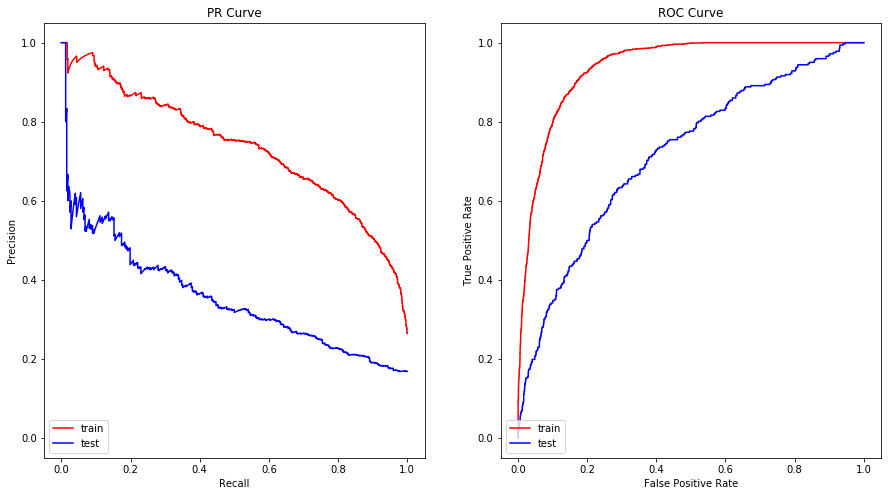

In [32]:
fig = roc_pr_curve_plot(lgbm,X_train,y_train,X_test,y_test)

In [33]:
for k_cols in [20,50,100,200,500,1000]:
    selectors = SelectKBest(f_classif, k=k_cols).fit(X_train, y_train)
    X_train_s = X_train[:,selectors.get_support()].copy()
    X_test_s = X_test[:,selectors.get_support()].copy()
    #X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed, stratify=y)
    lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
    lgbm.fit(X_train_s, y_train)
    pred = lgbm.predict_proba(X_test_s)[:,1]
    print(k_cols,average_precision_score(y_test,pred))

20 0.3365001936700173
50 0.3310094409694416
100 0.3410790892100034
200 0.33738672813194615
500 0.33738672813194615
1000 0.33738672813194615


In [34]:
k_cols = 100
selectors = SelectKBest(f_classif, k=k_cols).fit(X_train, y_train)
X_train_s = X_train[:,selectors.get_support()].copy()
X_test_s = X_test[:,selectors.get_support()].copy()
#X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed, stratify=y)
lgbm = LGBMClassifier(class_weight='balanced',random_state=seed)
lgbm.fit(X_train_s, y_train)
pred = lgbm.predict_proba(X_test_s)[:,1]
print(k_cols,average_precision_score(y_test,pred))

100 0.3410790892100034


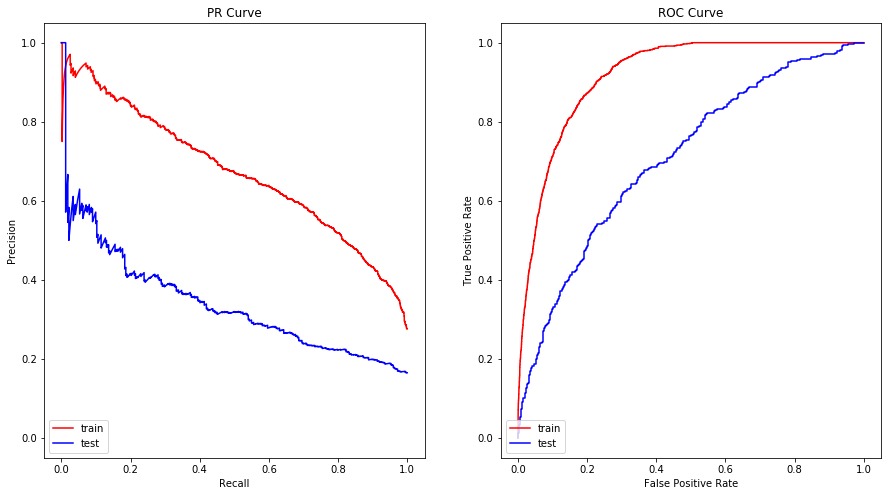

In [35]:
fig = roc_pr_curve_plot(lgbm,X_train_s,y_train,X_test_s,y_test)

In [36]:
cus_params = {'max_depth': 5, 'min_child_samples': 30, 'num_leaves': 15}
lgbm = LGBMClassifier(class_weight='balanced',random_state=seed,**cus_params)
lgbm.fit(X_train_s,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=5, min_child_samples=30, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=15,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

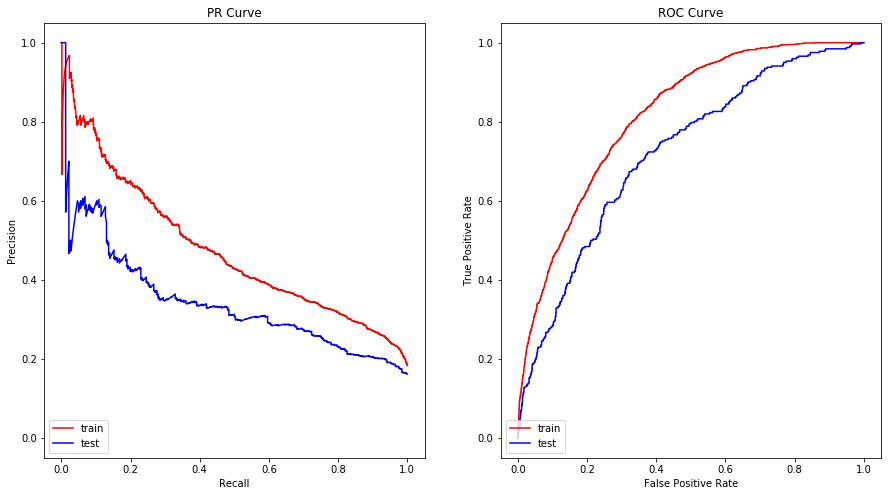

In [37]:
fig = roc_pr_curve_plot(lgbm,X_train_s,y_train,X_test_s,y_test)

In [38]:
pred = lgbm.predict(X_test_s)
print(classification_report(y_test,pred))
pred = lgbm.predict_proba(X_test_s)[:,1]
print('average precision score: ',average_precision_score(y_test,pred))


              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78      1678
         1.0       0.28      0.66      0.40       322

   micro avg       0.68      0.68      0.68      2000
   macro avg       0.60      0.67      0.59      2000
weighted avg       0.81      0.68      0.72      2000

average precision score:  0.3447217155707386


In [39]:
model = LGBMClassifier(class_weight='balanced',random_state=seed)
params_opt = {'num_leaves':[14, 15, 16], 
            'max_depth':[4, 5, 6],
            'min_child_samples': [20, 30, 40]}
gridSearchCV = GridSearchCV(estimator = model, 
                            param_grid = params_opt, 
                            scoring='average_precision',
                            n_jobs=-1,
                            iid=False, 
                            verbose=1,
                            cv=5)
gridSearchCV.fit(X_train_s,y_train)
print('best_params: ',gridSearchCV.best_params_)
print('best_average_precision_score',gridSearchCV.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s


best_params:  {'max_depth': 4, 'min_child_samples': 20, 'num_leaves': 14}
best_average_precision_score 0.36327273855229764


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    4.4s finished


In [40]:
best_params = gridSearchCV.best_params_
print('best paramaters: ', best_params)
print('best average precision score: ',gridSearchCV.best_score_)

best paramaters:  {'max_depth': 4, 'min_child_samples': 20, 'num_leaves': 14}
best average precision score:  0.36327273855229764


In [41]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=seed, **best_params)
lgbm.fit(X_train_s, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=4, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=14,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

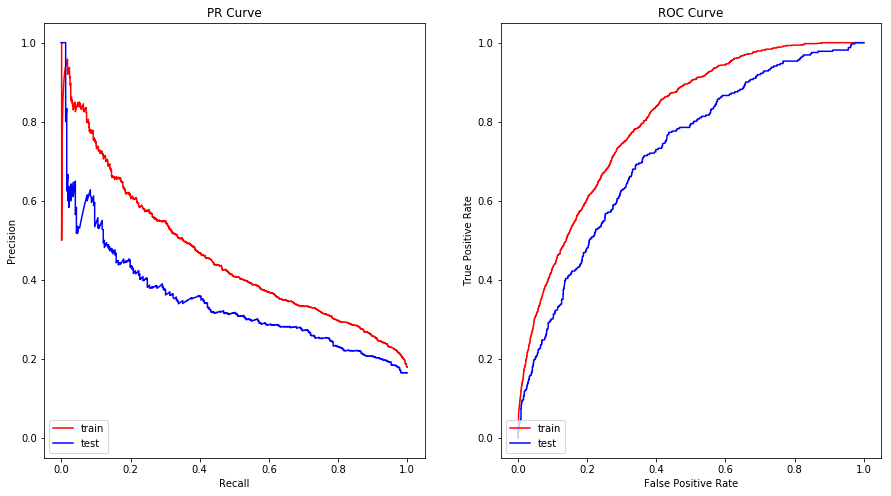

In [42]:
fig = roc_pr_curve_plot(lgbm,X_train_s, y_train, X_test_s, y_test)

In [43]:
pred = lgbm.predict(X_test_s)
print(classification_report(y_test, pred))
pred = lgbm.predict_proba(X_test_s)[:,1]
print('average precision score: ',average_precision_score(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78      1678
         1.0       0.28      0.66      0.39       322

   micro avg       0.67      0.67      0.67      2000
   macro avg       0.60      0.67      0.59      2000
weighted avg       0.81      0.67      0.72      2000

average precision score:  0.34612838224536246


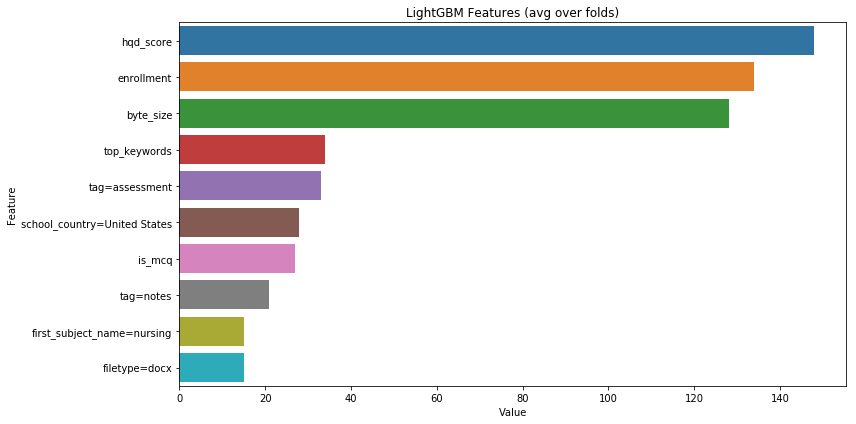

In [44]:
whole_feature_cols = np.array(v.get_feature_names())
selected_feature_cols = whole_feature_cols[selectors.get_support()]
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, selected_feature_cols)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
#b.set_yticklabels(b.get_yticks(), size = 15)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [45]:
feature_imp.sort_values(by="Value", ascending=False).head(10)

,Value,Feature
99,148,hqd_score
98,134,enrollment
97,128,byte_size
96,34,top_keywords
95,33,tag=assessment
94,28,school_country=United States
93,27,is_mcq
92,21,tag=notes
91,15,first_subject_name=nursing
90,15,filetype=docx


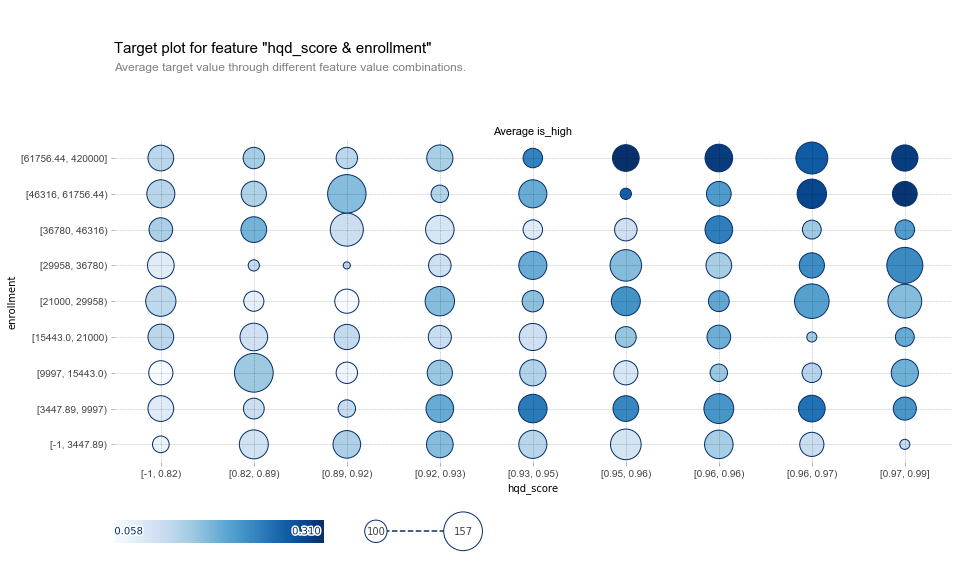

In [46]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df, features=['hqd_score', 'enrollment'], feature_names=['hqd_score', 'enrollment'], target='is_high'
)

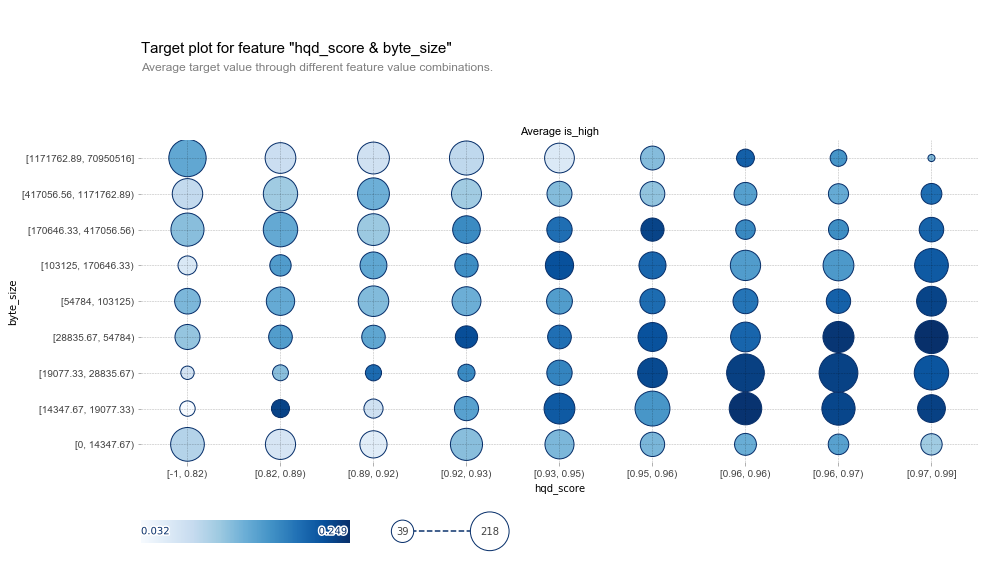

In [47]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df, features=['hqd_score', 'byte_size'], feature_names=['hqd_score', 'byte_size'], target='is_high'
)

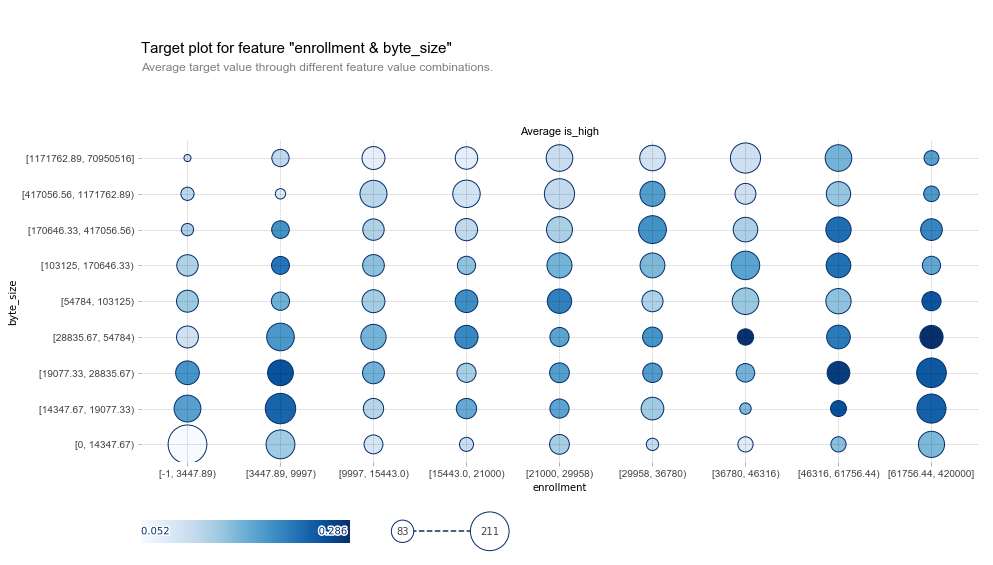

In [48]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df, features=['enrollment', 'byte_size'], feature_names=['enrollment', 'byte_size'], target='is_high'
)

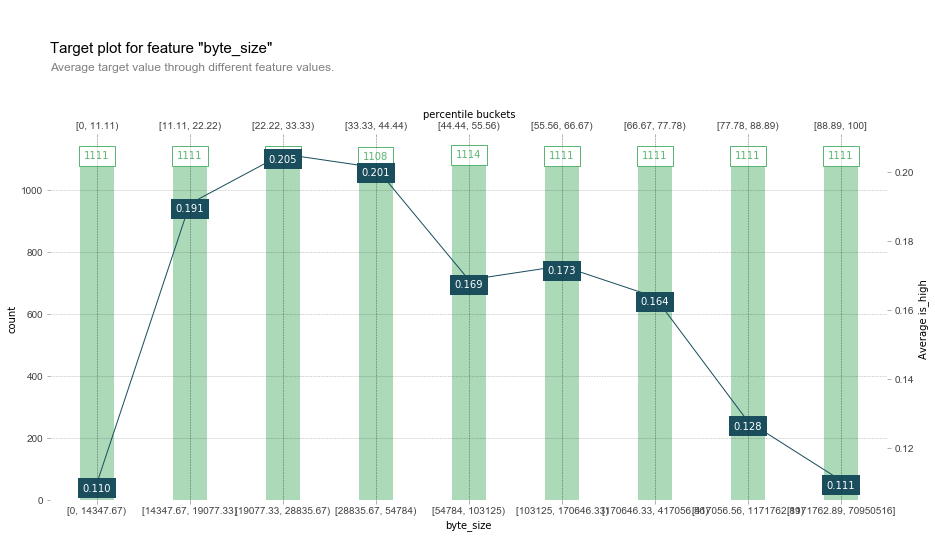

In [49]:
fig, axes, summary_df = info_plots.target_plot(
    df=df, feature='byte_size', feature_name='byte_size', target='is_high', show_percentile=True
)

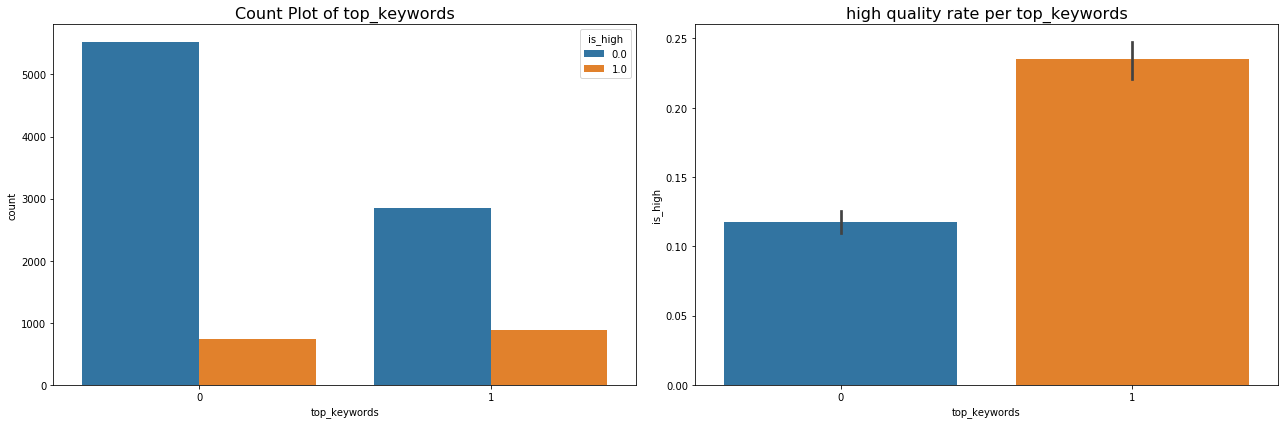

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='top_keywords', hue='is_high', data=df, ax=ax[0])
ax[0].set_title('Count Plot of top_keywords', fontsize=16)
sns.barplot(x='top_keywords', y='is_high', data=df, ax=ax[1]);
ax[1].set_title('high quality rate per top_keywords', fontsize=16)
plt.tight_layout()
plt.show()

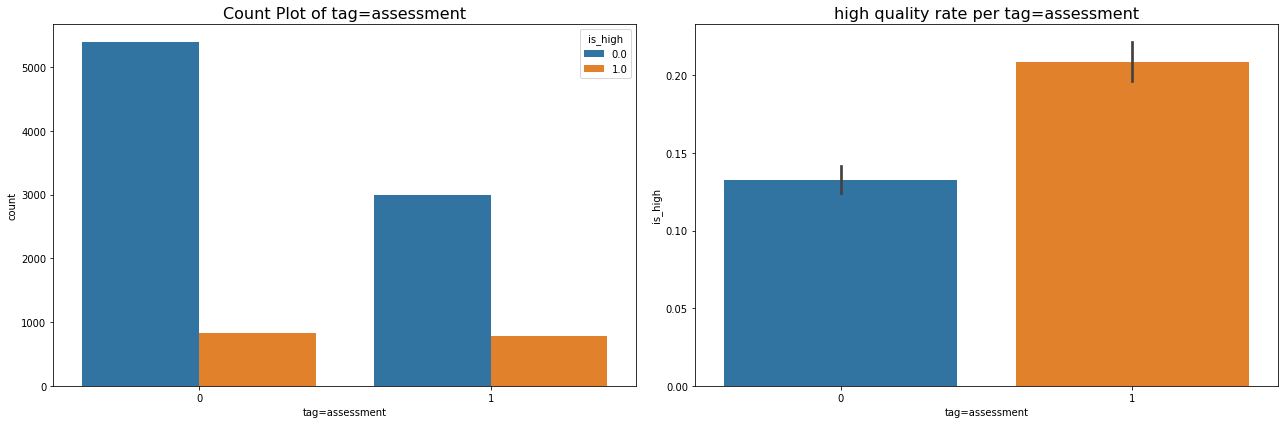

In [51]:
df['tag=assessment'] = np.where(df['tag'] == 'assessment',1,0)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='tag=assessment', hue='is_high', data=df, ax=ax[0])
ax[0].set_title('Count Plot of tag=assessment', fontsize=16)
sns.barplot(x='tag=assessment', y='is_high', data=df, ax=ax[1]);
ax[1].set_title('high quality rate per tag=assessment', fontsize=16)
plt.tight_layout()
plt.show()

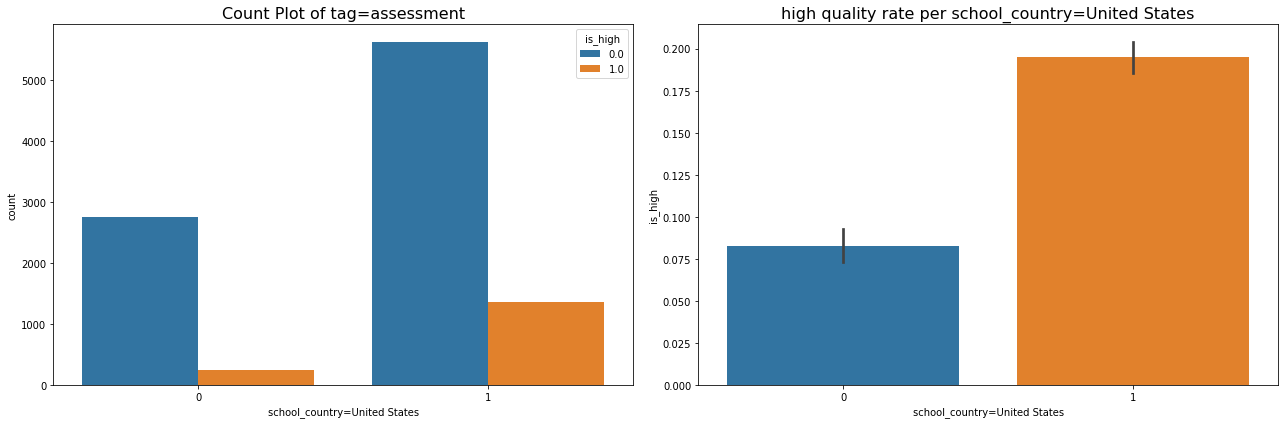

In [52]:
df['school_country=United States'] = np.where(df['school_country'] == 'United States',1,0)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='school_country=United States', hue='is_high', data=df, ax=ax[0])
ax[0].set_title('Count Plot of tag=assessment', fontsize=16)
sns.barplot(x='school_country=United States', y='is_high', data=df, ax=ax[1]);
ax[1].set_title('high quality rate per school_country=United States', fontsize=16)
plt.tight_layout()
plt.show()

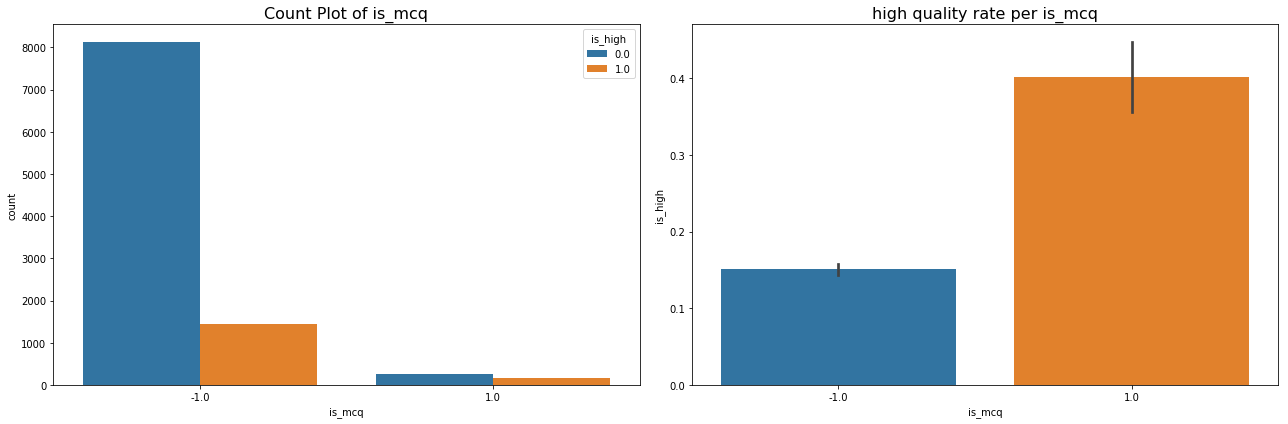

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='is_mcq', hue='is_high', data=df, ax=ax[0])
ax[0].set_title('Count Plot of is_mcq', fontsize=16)
sns.barplot(x='is_mcq', y='is_high', data=df, ax=ax[1]);
ax[1].set_title('high quality rate per is_mcq', fontsize=16)
plt.tight_layout()
plt.show()

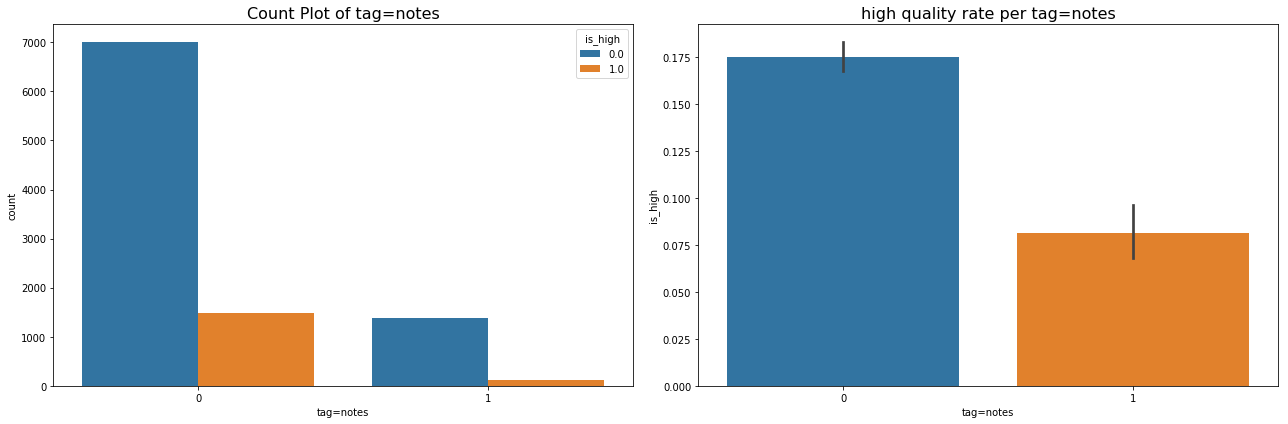

In [54]:
df['tag=notes'] = np.where(df['tag'] == 'notes',1,0)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='tag=notes', hue='is_high', data=df, ax=ax[0])
ax[0].set_title('Count Plot of tag=notes', fontsize=16)
sns.barplot(x='tag=notes', y='is_high', data=df, ax=ax[1]);
ax[1].set_title('high quality rate per tag=notes', fontsize=16)
plt.tight_layout()
plt.show()

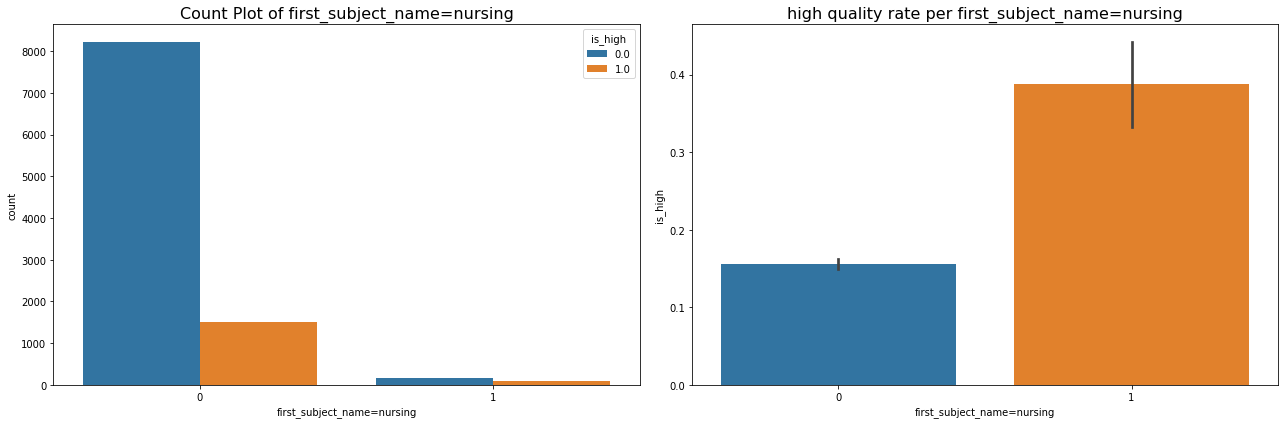

In [55]:
df['first_subject_name=nursing'] = np.where(df['first_subject_name'] == 'nursing',1,0)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='first_subject_name=nursing', hue='is_high', data=df, ax=ax[0])
ax[0].set_title('Count Plot of first_subject_name=nursing', fontsize=16)
sns.barplot(x='first_subject_name=nursing', y='is_high', data=df, ax=ax[1]);
ax[1].set_title('high quality rate per first_subject_name=nursing', fontsize=16)
plt.tight_layout()
plt.show()

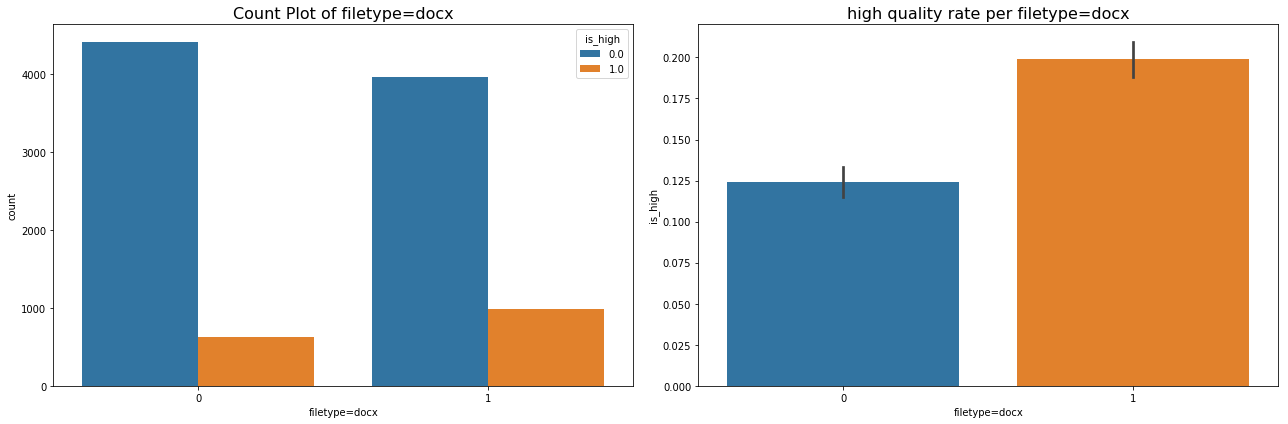

In [56]:
df['filetype=docx'] = np.where(df['filetype'] == 'docx',1,0)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='filetype=docx', hue='is_high', data=df, ax=ax[0])
ax[0].set_title('Count Plot of filetype=docx', fontsize=16)
sns.barplot(x='filetype=docx', y='is_high', data=df, ax=ax[1]);
ax[1].set_title('high quality rate per filetype=docx', fontsize=16)
plt.tight_layout()
plt.show()

In [61]:
! pip install nbconvert

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 455 kB 4.4 MB/s eta 0:00:01
  Using cached mistune-0.8.4-py2.py3-none-any.whl (16 kB)
     |████████████████████████████████| 75 kB 907 kB/s eta 0:00:01
  Using cached jupyter_core-4.6.3-py2.py3-none-any.whl (83 kB)
  Using cached entrypoints-0.3-py2.py3-none-any.whl (11 kB)
     |████████████████████████████████| 125 kB 21.1 MB/s eta 0:00:01
     |████████████████████████████████| 283 kB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 896 kB 22.8 MB/s eta 0:00

In [ ]:
!sudo apt-get install pandoc

Password: